# Simulating N samples simultaneously

Since we are only interested in ground level, we only need to store ground level data (Saves memory).

This means that our simulation can be reduce to just a 2D computation.

In [1]:
def run_simulation_2D(x, y, nx, ny, Lx, Ly, cx, cy, sx, sy):
    dx, dy = Lx/(nx-1), Ly/(ny-1)
    dt = 1
    tend = 1200
    t = 0

    cfl_x, cfl_y = cx * dt/dx, cy * dt/dy
    diff_x, diff_y = sx * dt/dx**2, sy * dt/dy**2

    u = np.zeros((nx+2, ny+2))
    sol = []
    source_x, source_y = nx // 2, ny // 2
    Q = 1e-6
    
    while t < tend:
        unew = u.copy()
        sol.append(u[1:-1, 1:-1])

         # Advection (Upwind Scheme)
        unew[1:-1, 1:-1] -= cfl_x * (u[1:-1, 1:-1] - u[1:-1, :-2])
        unew[1:-1, 1:-1] -= cfl_y * (u[1:-1, 1:-1] - u[:-2, 1:-1])
    
        # Diffusion (Central Differencing)
        unew[1:-1, 1:-1] += diff_x * (u[1:-1, 2:] - 2*u[1:-1, 1:-1] + u[1:-1, :-2])
        unew[1:-1, 1:-1] += diff_y * (u[2:, 1:-1] - 2*u[1:-1, 1:-1] + u[:-2, 1:-1])

        # Source Term
        unew[source_x, source_y] += Q * dt

        # Additional Source Points (forming a small area)
        offsets = [(-1, -1), (-1, 1), (1, -1), (1, 1), (-1, 0), (1, 0), (0, -1), (0, 1)]
        for dx, dy in offsets:
            unew[source_x + dx, source_y + dy] += Q * dt

        u = unew
        t += dt
        
    return np.array(sol)

In [ ]:
from joblib import Parallel, delayed
import numpy as np
import time as time

nx, ny= 51, 51  # Grid points
Lx, Ly = 5000, 5000  # Domain size in meters
x = np.linspace(-2500, 2500, nx)  # Centered at (0,0)
y = np.linspace(-2500, 2500, ny)
n = 1000
cx, cy = np.random.RandomState().uniform(0, 10, n), np.random.RandomState().uniform(0, 10, n)
sx, sy = np.random.RandomState().uniform(0, 1, n), np.random.RandomState().uniform(0, 1, n)
num_cores = -1

start_time = time.time()
results = Parallel(n_jobs=num_cores)(
    delayed(run_simulation_2D)(x, y, nx, ny, Lx, Ly, cx[i], cy[i], sx[i], sy[i])
    for i in range(n)
)
end_time = time.time()

print(f"Simulation took: {end_time-start_time}")

In [ ]:
observed = np.load("test.npy")
observed.shape, results[0].shape

We need to fix the shapes so that they correspond to each other.

Currently the simulated results is represented in an 3-D array, where each array within a timestep, and the respective concentration in the x-y grid. The observed is also in a 3-D array, however in shape (51, 51, 1200). This should mean that for each x-grid, it shows the value of y over time 1200.

Using `np.reshape` work in matching the dimensions. However, as the time and spatial dimensions are handled differently, it may not yield the same definition. Specifically, each slice in the observed in a seperate calculation per time step (instantaneous snapshots at t_i), whereas the simulation tracks concentration evolving over time. Time for simulated is the first axis, whereas it is last axis for observed.

In [4]:
results[0].reshape((51, 51, 1200)).shape, observed.shape

((51, 51, 1200), (51, 51, 1200))

An alternative here is to use `np.tranpose()`. This gives us more clarity into how we transform the simulated data.

Structure for simulated solution (axis 0: Time, axis 1:, Nx, axis 2: Ny) and analytical solution (axis 0: Nx, axis 1: Ny, axis 2: Time).

By using using `np.transpose(results[0], (1, 2, 0))`, the axes are rearranged to be:

- Simulated solution (axis 0: Nx, axis 1:, Ny, axis 2: Time)

Which is what we wanted.

In [5]:
np.transpose(results[0], (1, 2, 0)).shape

(51, 51, 1200)

The updated function now looks like this:

In [4]:
def run_simulation_2D(x, y, nx, ny, Lx, Ly, cx, cy, sx, sy):
    dx, dy = Lx/(nx-1), Ly/(ny-1)
    dt = 1
    tend = 1200
    t = 0

    cfl_x, cfl_y = cx * dt/dx, cy * dt/dy
    diff_x, diff_y = sx * dt/dx**2, sy * dt/dy**2

    u = np.zeros((nx+2, ny+2))
    sol = []
    source_x, source_y = nx // 2, ny // 2
    Q = 1e-6
    
    while t < tend:
        unew = u.copy()
        sol.append(u[1:-1, 1:-1])

         # Advection (Upwind Scheme)
        unew[1:-1, 1:-1] -= cfl_x * (u[1:-1, 1:-1] - u[1:-1, :-2])
        unew[1:-1, 1:-1] -= cfl_y * (u[1:-1, 1:-1] - u[:-2, 1:-1])
    
        # Diffusion (Central Differencing)
        unew[1:-1, 1:-1] += diff_x * (u[1:-1, 2:] - 2*u[1:-1, 1:-1] + u[1:-1, :-2])
        unew[1:-1, 1:-1] += diff_y * (u[2:, 1:-1] - 2*u[1:-1, 1:-1] + u[:-2, 1:-1])

        # Source Term
        unew[source_x, source_y] += Q * dt

        # Additional Source Points (forming a small area)
        offsets = [(-1, -1), (-1, 1), (1, -1), (1, 1), (-1, 0), (1, 0), (0, -1), (0, 1)]
        for dx, dy in offsets:
            unew[source_x + dx, source_y + dy] += Q * dt

        u = unew
        t += dt

    sol = np.transpose(sol, (1, 2, 0))
    return np.array(sol)

In [5]:
from joblib import Parallel, delayed
import numpy as np
import time as time

nx, ny= 51, 51  # Grid points
Lx, Ly = 5000, 5000  # Domain size in meters
x = np.linspace(-2500, 2500, nx)  # Centered at (0,0)
y = np.linspace(-2500, 2500, ny)
n = 50
cx, cy = np.random.RandomState().uniform(0, 10, n), np.random.RandomState().uniform(0, 10, n)
sx, sy = np.random.RandomState().uniform(0, 1, n), np.random.RandomState().uniform(0, 1, n)
num_cores = -1

start_time = time.time()
results = Parallel(n_jobs=num_cores)(
    delayed(run_simulation_2D)(x, y, nx, ny, Lx, Ly, cx[i], cy[i], sx[i], sy[i])
    for i in range(n)
)
end_time = time.time()

print(f"Simulation took: {end_time-start_time}")

Simulation took: 2.170866012573242


In [6]:
results[0].shape

(51, 51, 1200)

In [10]:
# At the middle x column
results[0][nx//2].shape

(51, 1200)

In [11]:
# The middle of the x, y grid
results[0][nx//2][ny//2].shape

(1200,)

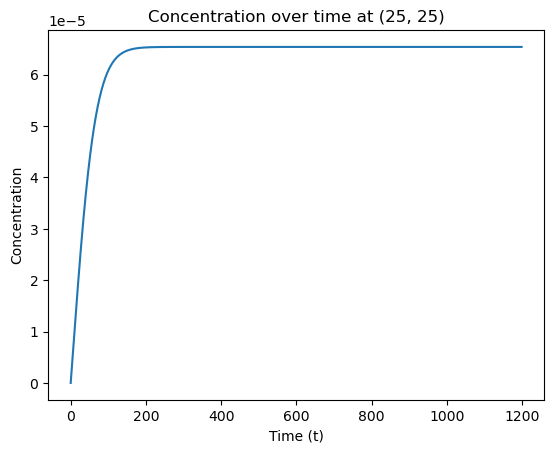

In [13]:
import matplotlib.pyplot as plt
plt.plot(results[0][nx//2][ny//2])
plt.title(f"Concentration over time at ({nx//2}, {ny//2})")
plt.xlabel("Time (t)")
plt.ylabel("Concentration")
plt.show()